
# $$\text{MathBot: A Transformer-based Math Word Problem Solver}$$
## Setup
Import the required python packages. Make sure to enable Tensorflow 2.x version.

In [1]:
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.8.2'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset
We used a baseline dataset named [MAWPS](https://aclanthology.org/N16-1136.pdf), consisting of $2,373$ math word
problems.
A [question generator](https://github.com/RahulSharmaNITT/MathWordProblem) for math word problems was used to generate similar
problems.

In [4]:
with open('/content/drive/MyDrive/MAWPS_Augmented.pkl', 'rb') as f:
  df = pickle.load(f)

This augmented MAWPS dataset consists of $38,144$ Math Word Problems.

In [5]:
df.shape

(38144, 2)

In [6]:
df.head(20)

,Question,Equation
963,A painter needed to paint 12 rooms in a build...,X=(7.0*(12.0-5.0))
3897,Brenda had 253 raspberry. John gripped some ra...,X = 253 - 66
27626,Casey wants to share some Bread among 17 frien...,X = 39 * 17
32530,Liza had 34 Press. Thomas furnished him some m...,X = 64 - 34
16266,George wants to distribute 125 mangos among 25...,X = 125 / 25
21122,Richard has 148 Marbles. Gary gave him 42 more...,X = 42 + 148
17377,Mary wants to impart 547 limes among 24 friend...,X = 547 / 24
20997,Juana had some apricot. He hash each apricot i...,X = 149 / 9
2745,Timmy had 86 watermelon. Kandi took 40 from hi...,X = 86 - 40
2080,William had 99 pear. Martin took 67 from him. ...,X = 99 - 67


In [7]:
X = list(df['Question'].values)

Padding with spaces.

In [8]:
def spacify(s):
    return ' '.join(list(s))

In [9]:
Y = list(df['Equation'].apply(lambda y: spacify(y)).values)

In [10]:
print(X[:10])
Y[:10]

[' A painter needed to paint 12 rooms in a building. Each room takes 7 hours to paint. If he already painted 5 rooms, how much longer will he take to paint the rest? ', 'Brenda had 253 raspberry. John gripped some raspberry. Now Brenda has 66  raspberry. How many did John grippeds?', 'Casey wants to share some Bread among 17 friends.If each friend get 39 Bread, then how many Bread john would have?', 'Liza had 34 Press. Thomas furnished him some more. Now Liza has 64 Press. How many did Thomas furnish him?', 'George wants to distribute 125 mangos among 25 friends. How many would each friend acquire?', 'Richard has 148 Marbles. Gary gave him 42 more. How many Marbles does Richard have altogether?', 'Mary wants to impart 547 limes among 24 friends. How many would each friend obtain?', 'Juana had some apricot. He hash each apricot into 9 slices. If total 149 apricot slices Juana make, then how many apricot Juana had?', 'Timmy had 86 watermelon. Kandi took 40 from him. Now How many watermel

['X = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'X   =   2 5 3   -   6 6',
 'X   =   3 9   *   1 7',
 'X   =   6 4   -   3 4',
 'X   =   1 2 5   /   2 5',
 'X   =   4 2   +   1 4 8',
 'X   =   5 4 7   /   2 4',
 'X   =   1 4 9   /   9',
 'X   =   8 6   -   4 0',
 'X   =   9 9   -   6 7']

## Data Preprocessing
• **Lowercase alphabets** —

`‘John has 20 apples.’` → `‘john has 20 apples.’`
<br/><br/>
• **Padding Spaces and removing extra whitespaces** —

`‘john has 20 apples.’` → `‘john has 2 0 apples .’`

`‘X = (7.0 ∗ (12.0 − 5.0))’` → `‘x = ( 7 . 0 ∗ ( 1 2 . 0 − 5 . 0 ) )’`
<br/><br/>
• **Tokenizing** —

`‘john has 2 0 apples .’` → `[‘john’, ‘has’, ‘2’, ‘0’, ‘apples’, ‘.’]`

`‘x = ( 7 . 0 ∗ ( 1 2 . 0 − 5 . 0 ) )’` → `[‘x’, ‘=‘, ‘(‘, ... , ’)’]`
<br/><br/>
• **Converting to Tensor Sequences** —

`[‘john’, ‘has’, ‘2’, ‘0’, ‘apples’, ‘.’]` → `[104, 2454, ..., 69, 911]`

`[‘x’, ‘=’, ‘(’, ... , ‘)’]` → $[2, 1, ..., 6]$
<br/><br/>
• **Zero Padding for equalizing sequence lengths** —

$[104, 2454, ..., 69, 911]$ → $[104, 2454, ..., 69, 911, 0, ..., 0, 0, 0]$

In [11]:
def preprocess_X(s):
    s = s.lower().strip()
    s = re.sub(r"([?.!,’])", r" \1 ", s)
    s = re.sub(r"([0-9])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = s.rstrip().strip()
    return s

def preprocess_Y(e):
    e = e.lower().strip()
    return e

In [12]:
X_pp = list(map(preprocess_X, X))
Y_pp = list(map(preprocess_Y, Y))

In [13]:
X_pp[:10]

['a painter needed to paint 1 2 rooms in a building . each room takes 7 hours to paint . if he already painted 5 rooms , how much longer will he take to paint the rest ?',
 'brenda had 2 5 3 raspberry . john gripped some raspberry . now brenda has 6 6 raspberry . how many did john grippeds ?',
 'casey wants to share some bread among 1 7 friends . if each friend get 3 9 bread , then how many bread john would have ?',
 'liza had 3 4 press . thomas furnished him some more . now liza has 6 4 press . how many did thomas furnish him ?',
 'george wants to distribute 1 2 5 mangos among 2 5 friends . how many would each friend acquire ?',
 'richard has 1 4 8 marbles . gary gave him 4 2 more . how many marbles does richard have altogether ?',
 'mary wants to impart 5 4 7 limes among 2 4 friends . how many would each friend obtain ?',
 'juana had some apricot . he hash each apricot into 9 slices . if total 1 4 9 apricot slices juana make , then how many apricot juana had ?',
 'timmy had 8 6 water

In [14]:
Y_pp[:10]

['x = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'x   =   2 5 3   -   6 6',
 'x   =   3 9   *   1 7',
 'x   =   6 4   -   3 4',
 'x   =   1 2 5   /   2 5',
 'x   =   4 2   +   1 4 8',
 'x   =   5 4 7   /   2 4',
 'x   =   1 4 9   /   9',
 'x   =   8 6   -   4 0',
 'x   =   9 9   -   6 7']

In [15]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    return tensor, lang_tokenizer

In [16]:
X_tensor, X_lang_tokenizer = tokenize(X_pp)

In [17]:
len(X_lang_tokenizer.word_index)

5887

In [18]:
Y_tensor, Y_lang_tokenizer = tokenize(Y_pp)

In [19]:
len(Y_lang_tokenizer.word_index)

45

In [20]:
previous_length = len(Y_lang_tokenizer.word_index)

Add integers for `<start>` and `<end>` tokens for input problems and target math expressions.

In [21]:
def append_head_tail(x, last_int):
    l = []
    l.append(last_int + 1)
    l.extend(x)
    l.append(last_int + 2)
    return l

In [22]:
X_tensor_list = [append_head_tail(i, len(X_lang_tokenizer.word_index)) for i in X_tensor]
Y_tensor_list = [append_head_tail(i, len(Y_lang_tokenizer.word_index)) for i in Y_tensor]

Padding the sequences with $0$'s to make them equal in length.

In [23]:
X_tensor = tf.keras.preprocessing.sequence.pad_sequences(X_tensor_list, padding='post')
Y_tensor = tf.keras.preprocessing.sequence.pad_sequences(Y_tensor_list, padding='post')

In [24]:
X_tensor

array([[5888,  104, 2454, ...,    0,    0,    0],
       [5888,  280,    6, ...,    0,    0,    0],
       [5888,  811,   43, ...,    0,    0,    0],
       ...,
       [5888,  380,   12, ...,    0,    0,    0],
       [5888,  167,    6, ...,    0,    0,    0],
       [5888,  404,    6, ...,    0,    0,    0]], dtype=int32)

In [25]:
Y_tensor

array([[46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0],
       ...,
       [46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0],
       [46,  2,  1, ...,  0,  0,  0]], dtype=int32)

Increasing the vocabulary size of the target by including some fodder words which won't be used. This is done to avoid problems later which manifest due to short vocabulary size.

In [26]:
keys = ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
        '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
        '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
        '46', '47', '48', '49', '50']

for idx,key in enumerate(keys):
    Y_lang_tokenizer.word_index[key] = len(Y_lang_tokenizer.word_index) + idx + 4

In [27]:
len(Y_lang_tokenizer.word_index)

86

#### **Train-Test Split** → 95 : 5

In [28]:
X_tensor_train, X_tensor_test, Y_tensor_train, Y_tensor_test = train_test_split(X_tensor, Y_tensor, test_size=0.05, random_state=42)

In [29]:
print(len(X_tensor_train), len(X_tensor_test), len(Y_tensor_train), len(Y_tensor_test)) 

36236 1908 36236 1908


## Hyperparameters

• Number of Encoder-Decoder layers, $N = 4$.

• Embedding dimension of input/output, $d_{model} = 128$.

• Number of Self-Attention heads, $h = 8$.

• Dropout Rate, $P_{drop} = 0$.

• Size of each mini-batch = $64$.

• Epochs = $17$.

In [30]:
TRAINING_SET_SIZE = len(X_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = np.floor(TRAINING_SET_SIZE/BATCH_SIZE)

data = tf.data.Dataset.from_tensor_slices((X_tensor_train, Y_tensor_train)).shuffle(TRAINING_SET_SIZE)
data = data.batch(BATCH_SIZE, drop_remainder=True)

num_layers = 4
d_model = 128       # Embedding dimension
dff = 512           # Dimensionality of inner-layer of FNN
num_heads = 8       # Number of parallel attention layers (heads)
dropout_rate = 0

X_vocabulary_size = len(X_lang_tokenizer.word_index) + 3
Y_vocabulary_size = len(Y_lang_tokenizer.word_index) + 3

In [31]:
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [32]:
data

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 124), dtype=tf.int32, name=None), TensorSpec(shape=(64, 66), dtype=tf.int32, name=None))>

In [33]:
X_batch_example, Y_batch_example = next(iter(data))

print(X_batch_example, Y_batch_example)

tf.Tensor(
[[5888  104 1139 ...    0    0    0]
 [5888  395  794 ...    0    0    0]
 [5888 1075    6 ...    0    0    0]
 ...
 [5888  484  137 ...    0    0    0]
 [5888 1678    6 ...    0    0    0]
 [5888  108    6 ...    0    0    0]], shape=(64, 124), dtype=int32) tf.Tensor(
[[46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]
 ...
 [46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]
 [46  2  1 ...  0  0  0]], shape=(64, 66), dtype=int32)


# The Transformer Model behind $\operatorname{MathBot}$

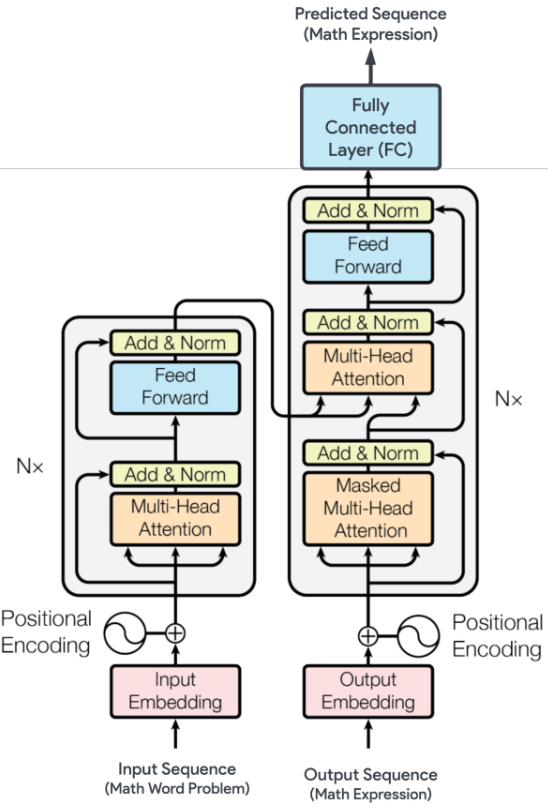

## Positional Encoding
Since transformers have no recurrence or convolution, we use positional encoding to let the model have an idea about the relative positions of the tokens in a sequence.
$$
$$
        \begin{aligned}
        \text{PE}(pos,2i)=sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)\\
        \text{PE}(pos,2i + 1)=cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
        \end{aligned}


In [34]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [35]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        
    pos_encoding = angle_rads[np.newaxis, ...]
        
    return tf.cast(pos_encoding, dtype=tf.float32)

# Masking
We mask all the padding elements so that they
are not considered as input to the model. The position of the
pad tokens are the positions at which the mask shows $1$ and
at the other locations it shows $0$. The subsequent tokens in
a sequence are masked using the look-ahead mask and this
mask indicates the entries that should be avoided.

In [36]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [37]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

# Scaled Dot-product Attention
A *“soft”* dictionary lookup which returns a weighted sum of the values in the
corpus. This weight represents the usefulness of a particular token in embedding the query token. Then, it is scaled by dividing with $\sqrt{d_k}$ inside softmax.
$$$$
    \begin{aligned}
        Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
    \end{aligned}

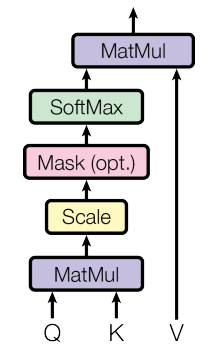

In [38]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# Multi-Head Attention
It is a combination of $h$ self-attention heads, where each head is sandwiched between two linear layers.
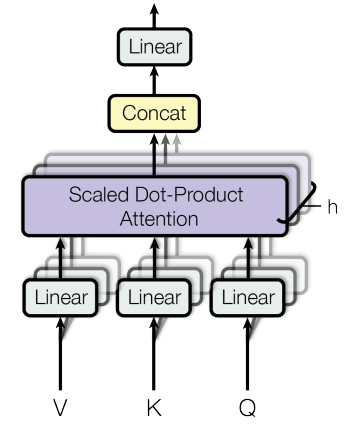

In [39]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
            
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights

# Point-wise Feed Forward Neural Network
Every encoder and decoder layer contains a fully connected feed-forward network. It is composed of two fully-connected layers with a $\operatorname{ReLU}$ activation function in between them.
$$$$
\begin{aligned}
        FFN(x) = \operatorname{max}(0,xW_1 + b_1)W_2 + b_2
        \end{aligned}

In [40]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

# Encoder
The encoder consists of $N$ layers and each
layer has 2 sub-layers. The first sub-layer is a multi-head
self attention mechanism layer and the second sub-layer is
a position-wise fully connected feed-forward neural network.
Each of these sub-layers is preceded by a skip connection or
residual connection and succeeded by a layer normalization block. They result in outputs of dimension $d_{model}$
to facilitate the skip connections. The residual connections are
important as they assist in overcoming the vanishing gradient
problem in deep network architectures.
$$$$
\begin{aligned}
        \operatorname{Encoder}(x) = \operatorname{LayerNorm}(x + \operatorname{Sublayer}(x))
        \end{aligned}

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # normalize data per feature instead of batch
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # Multi-head attention layer
        attn_output, _ = self.mha(x, x, x, mask) 
        attn_output = self.dropout1(attn_output, training=training)
        # add residual connection to avoid vanishing gradient problem
        out1 = self.layernorm1(x + attn_output)
        
        # Feedforward layer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # add residual connection to avoid vanishing gradient problem
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [42]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)
        
        # Create encoder layers (count: num_layers)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
    
        self.dropout = tf.keras.layers.Dropout(rate)
            
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x

# Decoder
The decoder consists of $N$ layers and each layer has $3$ sub-layers. Two of the sub-layers are the same as those of the encoder. The third sub-layer utilizes the outputs of the encoder stack and performs multi-head attention over
them. Decoder feeds on two types of inputs which are, the outputs of the encoder and positionally encoded target output embeddings. And just like the encoder, decoder also has subsequent layer normalization blocks and incorporation of skip connections after and before each sub-layer respectively. The principal task of decoder is to predict token at position $n$ by looking at all the preceding $n−1$ tokens using the look-ahead mask. The predicted sequence is then passed through a fully-connected neural network layer to generate the final math expression.

In [43]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
        
    def call(self, x, enc_output, training, 
            look_ahead_mask, padding_mask):

        # Masked multihead attention layer (padding + look-ahead)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        # again add residual connection
        out1 = self.layernorm1(attn1 + x)
        
        # Masked multihead attention layer (only padding)
        # with input from encoder as Key and Value, and input from previous layer as Query
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        # again add residual connection
        out2 = self.layernorm2(attn2 + out1)
        
        # Feedforward layer
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        # again add residual connection
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

In [44]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        # Create decoder layers (count: num_layers)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, 
            look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x += self.pos_encoding[:,:seq_len,:]
        
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                look_ahead_mask, padding_mask)
        
        # store attenion weights, they can be used to visualize while translating
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x, attention_weights

In [45]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                            input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                            target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, 
            look_ahead_mask, dec_padding_mask):

        # Pass the input to the encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        # Pass the encoder output to the decoder
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # Pass the decoder output to the last linear layer
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Optimizer
We used $\operatorname{Adam}$ with a custom learning
rate scheduler as our optimizer. The learning rate was set
according to,
$$$$
\begin{aligned}
        lrate = d_{model}^{-0.5} \cdot \operatorname{min}(n^{-0.5},n \cdot w^{-1.5})
        \end{aligned}

where, $d_{model}$ is the embedding dimension, $n$ is the step number and $w$ is the number of warm-up steps. Here, warm-up steps $w$ simply insinuates that the learning rate rises linearly for the initial $w$ training steps. We set $\beta_1 = 0.9$, $\beta_2 = 0.98$, $\epsilon = 10^{-9}$ and $w = 4000$ for our model's Adam optimizer.

In [47]:
learning_rate = CustomSchedule(d_model)

# Adam optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Performance Metric
As output sequences are padded, it is important to apply a padding mask when calculating the loss. We used Sparse Categorical Cross-entropy for loss and Mean for accuracy. In the test-phase we also calcuated the BLEU (BiLingual Evaluation Understudy) score of our model to assess its translation quality.
The BLEU score is computed as,
$$$$
\begin{aligned}
        \operatorname{BLEU} = \underbrace{\operatorname{min}\left(1,e^{1-\frac{l_{reference}}{l_{output}}}\right)}_{\text{brevity penalty}} \cdot \underbrace{(\prod_{i=1}^{4}precision_i)^{\frac{1}{4}}}_{\text{n-gram overlap}} \\
        precision_i = \frac{\sum_{s \in \operatorname{Cand-Corpus}} \sum_{i \in s} \operatorname{min}(m_{cand}^i, m_{ref}^{i})}{w_t^i}
        \end{aligned}

In [49]:
def loss_function(real, pred):
    # Apply a mask to paddings (0)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    accuracies = tf.equal(tf.cast(real, dtype=tf.int32), tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

    mask = tf.math.logical_not(tf.math.equal(tf.cast(real, dtype=tf.int32), 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_accuracy_mean = tf.keras.metrics.Mean(name='train_accuracy_mean')

In [51]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          X_vocabulary_size, Y_vocabulary_size, 
                          pe_input=X_vocabulary_size, 
                          pe_target=Y_vocabulary_size,
                          rate=dropout_rate)

In [52]:
def create_masks(inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    # Look ahead mask (for hiding the rest of the sequence in the 1st decoder attention layer)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [53]:
# !rm -r /content/drive/MyDrive/MLProject/checkpoints/training_checkpoints/moops_transformer

In [54]:
drive_root = '/content/drive/MyDrive/'

Retrieve last saved checkpoint.

In [55]:
checkpoint_directory = os.path.join(drive_root, "MLProject/checkpoints")
checkpoint_directory = os.path.join(checkpoint_directory, "training_checkpoints/moops_transfomer")

print("Checkpoints directory is", checkpoint_directory)
if os.path.exists(checkpoint_directory):
    print("Checkpoints folder already exists!")
else:
    print("Creating a checkpoints directory...")
    os.makedirs(checkpoint_directory)


checkpoint = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_directory, max_to_keep=None)

Checkpoints directory is /content/drive/MyDrive/MLProject/checkpoints/training_checkpoints/moops_transfomer
Checkpoints folder already exists!


In [56]:
last_checkpoint = ckpt_manager.latest_checkpoint
last_checkpoint

'/content/drive/MyDrive/MLProject/checkpoints/training_checkpoints/moops_transfomer/ckpt-17'

In [57]:
if last_checkpoint:
    current_epoch_num = int(last_checkpoint.split('/')[-1].split('-')[-1])
    checkpoint.restore(last_checkpoint)
    print('Last checkpoint has been restored!')
else:
    current_epoch_num = 0

Last checkpoint has been restored!


In [58]:
print(current_epoch_num)

17


# Training

In [59]:
EPOCHS = 17

In [60]:
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                    True, 
                                    enc_padding_mask, 
                                    look_ahead_mask, 
                                    dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    train_accuracy_mean(accuracy_function(tar_real, predictions))

In [61]:
for epoch in range(current_epoch_num, EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_accuracy_mean.reset_states()
    
    # inp -> math problem, tar -> expression
    for (batch, (inp, tar)) in enumerate(data):
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print (f'Epoch {epoch + 1}, Batch {batch}, Loss {train_loss.result():.5f},\
             SC Accuracy {train_accuracy.result():.5f}, Mean Accuracy {train_accuracy_mean.result():.5f}')
        
    ckpt_save_path = ckpt_manager.save()
    print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
        
    print (f'Epoch {epoch + 1}, Loss {train_loss.result():.5f},\
     SC Accuracy {train_accuracy.result():.5f}, Mean Accuracy {train_accuracy_mean.result():.5f}')

    print (f'Training time for this epoch: {(time.time() - start):.5f} seconds\n')

In [62]:
MAX_LENGTH = 40

In [63]:
def evaluate(input_problem):
    start_token = [len(X_lang_tokenizer.word_index)+1]
    end_token = [len(X_lang_tokenizer.word_index)+2]
    
    # input_problem is the word problem, hence adding the start and end token
    input_problem = start_token + [X_lang_tokenizer.word_index[i] for i in preprocess_X(input_problem).split(' ')] + end_token
    encoder_input = tf.expand_dims(input_problem, 0)
    
    # start with expression's start token
    decoder_input = [previous_length+1]
    output = tf.expand_dims(decoder_input, 0)
        
    for i in range(MAX_LENGTH):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(encoder_input, output)
    
        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    look_ahead_mask,
                                                    dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == previous_length + 2:
            return tf.squeeze(output, axis=0), attention_weights
        
        # concatenate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [64]:
def plot_attention_weights(attention, problem, result, layer):
    fig = plt.figure(figsize=(8, 16))
    
    sentence = preprocess_X(problem)
    
    attention = tf.squeeze(attention[layer], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(4, 2, head+1)
        
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        
        fontdict = {'fontsize': 11}
        
        ax.set_xticks(range(len(sentence.split(' '))+2))
        ax.set_yticks(range(len([Y_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                            if i < len(Y_lang_tokenizer.word_index) and i not in [0,previous_length+1,previous_length+2]])+3))
        
        
        ax.set_ylim(len([Y_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                            if i < len(Y_lang_tokenizer.word_index) and i not in [0,previous_length+1,previous_length+2]]), -0.5)
            
        ax.set_xticklabels(
            ['<start>']+sentence.split(' ')+['<end>'], 
            fontdict=fontdict, rotation=90)
        
        ax.set_yticklabels([Y_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                            if i < len(Y_lang_tokenizer.word_index) and i not in [0,previous_length+1,previous_length+2]], 
                        fontdict=fontdict)
        
        ax.set_xlabel(f'Head {head+1}')
    
    plt.tight_layout()
    plt.show()

In [65]:
def solve(problem, plot='', plot_Attention_Weights=False):
    prediction, attention_weights = evaluate(problem)
    predicted_expression = [Y_lang_tokenizer.index_word[i] \
                          for i in list(prediction.numpy()) \
                          if (i < len(Y_lang_tokenizer.word_index) and i not in [0,46,47])]
    print(f'Input: {problem}')
    print('Predicted translation: {}'.format(' '.join(predicted_expression)))
    
    if plot_Attention_Weights:
        plot_attention_weights(attention_weights, problem, prediction, plot)

In [66]:
def evaluate_testset(input_problem):
    start_token = [len(X_lang_tokenizer.word_index)+1]
    end_token = [len(X_lang_tokenizer.word_index)+2]
    
    # input_problem is the word problem, hence adding the start and end token
    input_problem = start_token + list(input_problem.numpy()[0]) + end_token
    encoder_input = tf.expand_dims(input_problem, 0)
    
    # start with expression's start token
    decoder_input = [previous_length+1]
    output = tf.expand_dims(decoder_input, 0)
        
    for i in range(MAX_LENGTH):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(encoder_input, output)
    
        predictions, attention_weights = transformer(encoder_input, 
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    look_ahead_mask,
                                                    dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == previous_length + 2:
            return tf.squeeze(output, axis=0), attention_weights
        
        # concatenate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [67]:
data_test = tf.data.Dataset.from_tensor_slices((X_tensor_test, Y_tensor_test)).shuffle(len(X_tensor_test))
data_test = data_test.batch(1, drop_remainder=True)

In [68]:
Y_true = []
Y_pred = []
correctCount = 0

idx = 0
for(X_test_batch, Y_test_batch) in iter(data_test):
    idx += 1
    if idx % 10 == 0:
        print(f'Samples tested: {idx}, Correctly solved: {correctCount}')
    ground_truth_expression = ''
    for i in Y_test_batch.numpy()[0]:
        if i not in [0, previous_length + 1, previous_length + 2]:
            ground_truth_expression += (Y_lang_tokenizer.index_word[i] + ' ')

    Y_true.append([ground_truth_expression.split(' ')[:-1]])

    prediction, attention_weights = evaluate_testset(X_test_batch)
    predicted_expression = [Y_lang_tokenizer.index_word[i] \
                            for i in list(prediction.numpy()) \
                            if (i < len(Y_lang_tokenizer.word_index) and i not in [0, previous_length + 1, previous_length + 2])]
    Y_pred.append(predicted_expression)
    if ground_truth_expression.split(' ')[:-1] == predicted_expression:
        correctCount += 1

Samples tested: 10, Correctly solved: 5
Samples tested: 20, Correctly solved: 13
Samples tested: 30, Correctly solved: 20
Samples tested: 40, Correctly solved: 29
Samples tested: 50, Correctly solved: 34
Samples tested: 60, Correctly solved: 44
Samples tested: 70, Correctly solved: 52
Samples tested: 80, Correctly solved: 60
Samples tested: 90, Correctly solved: 67
Samples tested: 100, Correctly solved: 75
Samples tested: 110, Correctly solved: 81
Samples tested: 120, Correctly solved: 90
Samples tested: 130, Correctly solved: 99
Samples tested: 140, Correctly solved: 106
Samples tested: 150, Correctly solved: 114
Samples tested: 160, Correctly solved: 119
Samples tested: 170, Correctly solved: 124
Samples tested: 180, Correctly solved: 131
Samples tested: 190, Correctly solved: 137
Samples tested: 200, Correctly solved: 143
Samples tested: 210, Correctly solved: 150
Samples tested: 220, Correctly solved: 156
Samples tested: 230, Correctly solved: 166
Samples tested: 240, Correctly sol

In [69]:
print(len(Y_true), len(Y_pred))

1908 1908


# Results
• Training-set Accuracy → $98.4\%$

• Test-set Accuracy → $73.7\%$

• Corpus BLEU (BiLingual Evaluation Understudy) → $87.2\%$

In [70]:
print('Corpus BLEU score of the model: ', corpus_bleu(Y_true, Y_pred))

Corpus BLEU score of the model:  0.8718046101593423


In [71]:
print(f'Accuracy of the model: {(correctCount/len(X_tensor_test))*100}%')

Accuracy of the model: 73.74213836477988%


In [72]:
sample_problem = ' '.join([X_lang_tokenizer.index_word[i] \
                           for i in X_tensor_test[69] \
                           if i not in [0, len(X_lang_tokenizer.word_index)+1, len(X_lang_tokenizer.word_index)+2]])

In [73]:
sample_problem

'sarah wants to diverge 7 6 4 plums among 2 3 friends . how many would each friend experience ?'

Input: sarah wants to diverge 7 6 4 plums among 2 3 friends . how many would each friend experience ?
Predicted translation: x = 7 6 4 / 2 3


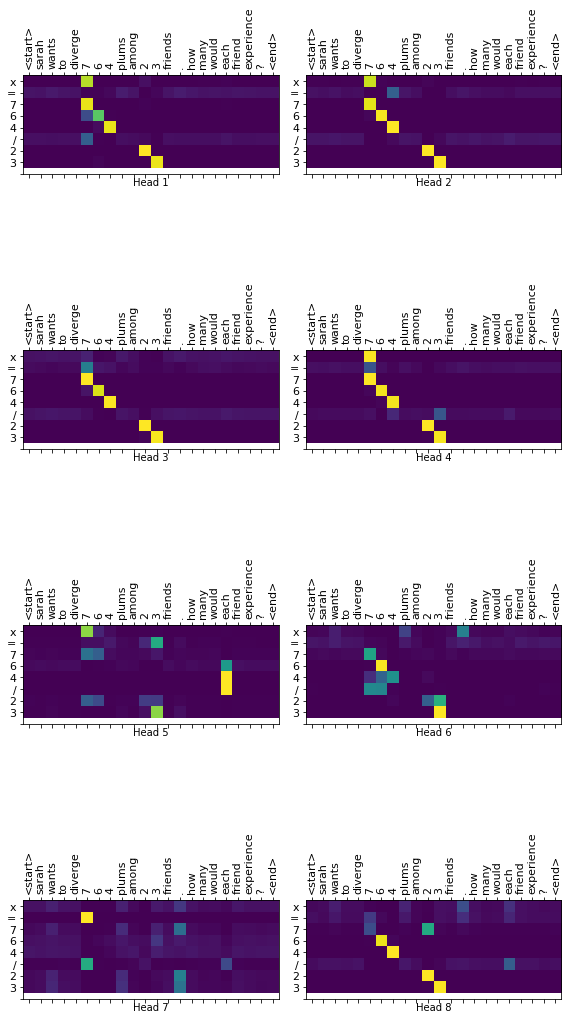

In [74]:
solve(sample_problem, plot='decoder_layer4_block2', plot_Attention_Weights=True)

In [75]:
solve('A painter needed to paint 12 rooms in a building. Each room takes 7 hours to paint.\
 If he already painted 5 rooms, how much longer will he take to paint the rest?'\
 , plot='', plot_Attention_Weights=False)

Input: A painter needed to paint 12 rooms in a building. Each room takes 7 hours to paint. If he already painted 5 rooms, how much longer will he take to paint the rest?
Predicted translation: x = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )


In [76]:
solve('Rachel bought two coloring books. One had 23 pictures and the other had 32. After one week she had colored 19 of the pictures. How many pictures does she still have to color?', plot='', plot_Attention_Weights=False)

Input: Rachel bought two coloring books. One had 23 pictures and the other had 32. After one week she had colored 19 of the pictures. How many pictures does she still have to color?
Predicted translation: x = ( ( 2 3 . 0 + 3 2 . 0 ) - 1 9 . 0 )


In [77]:
solve('Jerry had 135 pens. John took 19 pens from him. How many pens Jerry have left?')

Input: Jerry had 135 pens. John took 19 pens from him. How many pens Jerry have left?
Predicted translation: x = 1 3 5 - 1 9


In [80]:
solve('Donald had some apples. Hillary took 69 apples from him. Now Donald has 100 apples. How many apples Donald had before?')

Input: Donald had some apples. Hillary took 69 apples from him. Now Donald has 100 apples. How many apples Donald had before?
Predicted translation: x = 1 0 0 + 6 9


### Our model has been deployed publicly in Hugging Face!
Click here to check it out → https://huggingface.co/spaces/Casio991ms/MathBot

## Helpful links for more details
• Vaswani, Ashish, et al. "[Attention is all you need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)." Advances in neural information processing systems 30 (2017).

• TensorFlow tutorial on Transformers:

> https://www.tensorflow.org/text/tutorials/transformer

> https://www.youtube.com/watch?v=LE3NfEULV6k



In [ ]:
! pip install gradio
import gradio as gr

def Solve(input):
    return solve(input)

interface = gr.Interface(fn = Solve, inputs = 'text', outputs = 'text')
interface.launch()